In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 300)
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

/Users/jitsen/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jitsen/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Read in Review Dataset

In [25]:
df = pd.read_csv('review_final.csv')

In [26]:
final_df = df[(~df['review_text'].isnull())]
final_df = final_df[(final_df['review_text'].apply(lambda x: len(x)>0))]

In [27]:
final_df['title'].nunique()

477

### Calculate Sentiment

In [28]:
final_df['sentiment'] = final_df['review_text'].apply(lambda x: TextBlob(x).polarity)

### Calculate length of review

In [29]:
final_df['review_length'] = final_df['review_text'].apply(lambda x: len(x))

In [30]:
final_df['list_date'] = pd.to_datetime(final_df['list_date']).apply(lambda x: x.timestamp())

In [40]:
filter_df = final_df[final_df['rank'] == final_df.groupby(['title',
                                                           'publisher'])['rank'].transform(max)]

In [42]:
len(filter_df)

1347

### Fit Regression Model and Get R^2 and Adjusted R^2

In [55]:
model_df = filter_df[['rank', 
                      'weeks_on_list',
                      'publisher',
                      'list_title',
                      'sentiment']]

df_dummy = pd.get_dummies(model_df, 
                          drop_first=False, 
                          columns=['publisher',
                                  'list_title'])

stats_model = LinearRegression(fit_intercept=True, normalize = True)
X = df_dummy.drop(labels=['rank'],
                  axis=1)
y = df_dummy['rank'] 
stats_model.fit(X, y)
df_dummy['pred_rank'] = stats_model.predict(X)
stats_model.score(X, y), 1 - (1-stats_model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

(0.6254693173682369, 0.544196836507818)

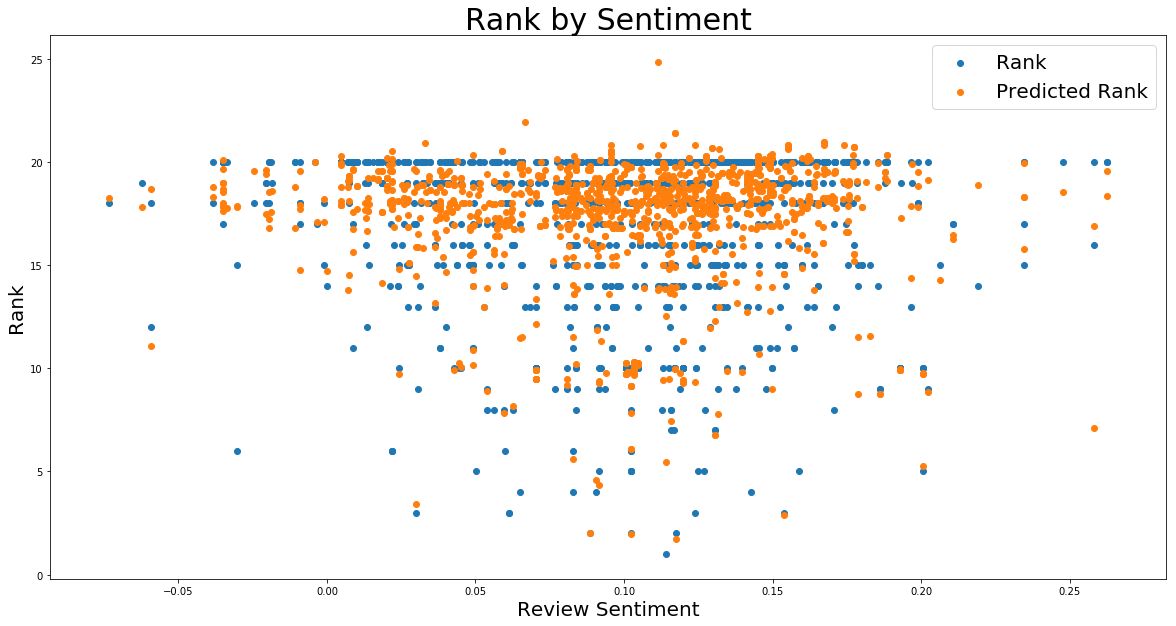

In [56]:
plt.figure(figsize = (20,10));
plt.scatter(x=df_dummy['sentiment'], y=df_dummy['rank'],label = 'Rank');
plt.scatter(x=df_dummy['sentiment'], y=df_dummy['pred_rank'], label = 'Predicted Rank')
plt.ylabel('Rank', fontsize = 20);
plt.xlabel('Review Sentiment', fontsize = 20);
plt.title('Rank by Sentiment', fontsize = 30);
plt.legend(fontsize = 20);

### Linear Regression with Cross Validation

In [69]:
def lr_performance(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    return lr.score(X_test, y_test), lr.score(X_train, y_train)

def test_train_iterations(X,y,z=10): 
    for i in range(z):
        print(lr_performance(X,y))

test_train_iterations(X,y,10)

(-8.925081762735416e+17, 0.7002882200508904)
(-3.5686272359974638e+19, 0.6789478092692737)
(-1.4268395581477482e+19, 0.6594718360656221)
(-2.26859497474903e+21, 0.6587389163269435)
(-8.46655627198704e+18, 0.6460025587823743)
(0.38685703146936545, 0.6522016109649851)
(-6.278707783494026e+18, 0.6996666621567511)
(-2.2675758922695174e+20, 0.6886306709242253)
(-5.895764753322552e+18, 0.6596530492255517)
(-1.3477241739899605e+19, 0.6722837407042961)


### Random Forest Regresssion with Cross Validation

In [73]:
def rf_performance(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rand_forest = RandomForestRegressor(n_estimators=5, min_samples_split=2)
    rand_forest.fit(X_train, y_train)
    return rand_forest.score(X_test, y_test), rand_forest.score(X_train, y_train)

def test_train_iterations(X,y,z=10): 
    for i in range(z):
        print(rf_performance(X,y))

test_train_iterations(X,y,10)

(0.3767646937647551, 0.8954832981088157)
(0.47237327231918025, 0.8910313003920003)
(0.36698665946285197, 0.8994323471337952)
(0.466375100489401, 0.8930836005116037)
(0.5106266711079501, 0.89596965869757)
(0.3938157170560532, 0.8573558976588636)
(0.43333993466404674, 0.908344589444623)
(0.47838811058942293, 0.9077012842094381)
(0.4443655099044287, 0.8835590340598626)
(0.4470172741555088, 0.8873790177146148)


### Feature Importances

In [76]:
rand_forest = RandomForestRegressor(n_estimators=5, min_samples_split=2)
rand_forest.fit(X, y)
sorted(zip(X.columns,rand_forest.feature_importances_),key = lambda x: x[1], reverse=True)[:10]

[('list_title_Picture Books', 0.1515732788849206),
 ('sentiment', 0.09573784266599443),
 ('weeks_on_list', 0.0929422744577588),
 ('publisher_Three Rivers', 0.03859138572039649),
 ('list_title_Paperback Nonfiction', 0.03817629989087389),
 ('list_title_Paperback Books', 0.03500216375340739),
 ('list_title_Hardcover Nonfiction', 0.03363158448249122),
 ('list_title_Hardcover Graphic Books', 0.03047671230847753),
 ('list_title_Paperback Graphic Books', 0.025078589419058956),
 ('list_title_Trade Fiction Paperback', 0.021993159461853727)]